In [ ]:
import matplotlib.pyplot as plt
from scipy.special import erfc
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from functions import get_params_string
from Paper.figure_scripts import common

In [2]:
def phi(a):
    return np.minimum(1, a)

# Define Δ(s, ε)
def Delta(s, eps):
    return np.abs(phi(s) - phi(s * np.exp(eps)))

def Delta2(s, eps):
    return Delta(s,eps) - s*np.abs(1 -  np.exp(eps))

def Delta3(s, eps):
    return Delta(s,eps) - (1 -  np.exp(-np.abs(eps)))

In [3]:
def bound_KL(sigma: float) -> float:
    return sigma

def bound_avg(sigma: float) -> float:
    return 2 * (1 - np.exp(sigma ** 2) * erfc(sigma))

In [4]:
n = 12
sigma_list = np.logspace(-6, 1, 20)
n_seeds = 10
seeds = [100 * i for i in range(n_seeds)]

In [5]:
import numpy as np
import pickle

obs_names = ["even", "X"]
label_map = {"even":r"$\langle\Pi_{\text{Even}}\rangle$", "X": r"$\langle\sigma^x_1\rangle$"}

data = {}
sampling_error = {}

for obs in obs_names:
    acceptances = np.full((2, len(sigma_list), len(seeds)), np.nan)
    means = np.full((2, len(sigma_list), len(seeds)), np.nan)
    mc_errors = np.full((2, len(sigma_list), len(seeds)), np.nan)

    for i, sigma in enumerate(sigma_list):
        for j, seed in enumerate(seeds):
            acceptances[0, i, j] = np.load(f"./data_evs/{n}/{seed}/{obs}/acc_ref_{sigma:1.7f}.npy")
            acceptances[1, i, j] = np.load(f"./data_evs/{n}/{seed}/{obs}/acc_noisy_{sigma:1.7f}.npy")

            with open(f"./data_evs/{n}/{seed}/{obs}/stats_ref_{sigma:1.7f}.c", "rb") as f:
                stats_ref = pickle.load(f)
            with open(f"./data_evs/{n}/{seed}/{obs}/stats_noisy_{sigma:1.7f}.c", "rb") as f:
                stats_noisy = pickle.load(f)

            means[0, i, j] = stats_ref["Mean"]
            means[1, i, j] = stats_noisy["Mean"]
            mc_errors[0, i, j] = stats_ref["Sigma"]
            mc_errors[1, i, j] = stats_noisy["Sigma"]

    sampling_error[obs] = np.nanmax(
        4 * np.sqrt((mc_errors[0] ** 2 + mc_errors[1] ** 2) / np.abs(means[0])),
        axis=1,
    )

    data[obs] = {
        "means": means,
        "acceptances": acceptances,
        "mc_errors": mc_errors,
    }


In [6]:
L = 16
n_dim = 1
PBC = True
model_label = "TFIM"
hs = np.arange(0.5, 10, 0.5)
model_params = lambda x: {"J": 1, "h": x}
N_therm = 2 ** np.arange(10, 20)

folder = f"{PROJECT_ROOT}Data/LPSE/Noisy_rbm/Acceptance/"
sigmas = np.concatenate(([0], np.logspace(-3, 3, 100))) 

In [7]:
acceptance = np.zeros((len(hs), len(sigmas)))

for m, h in enumerate(hs):
    params_str = get_params_string(model_params(h))
    df = pd.read_csv(f"{folder}{model_label}{params_str}_L{L}_{n_dim}dim.csv")
    mask = df["Sigma"].apply(lambda x: np.any(np.isclose(x, sigmas, rtol=1e-2)))
    df = df[mask].sort_values(by="Sigma")
    acceptance[m, :] = df["Acceptance"].to_numpy()

folder = f"{PROJECT_ROOT}Data/LPSE/Ratio/"
ratio_mean = []
ratio_error = []
ratio_median = []

for h in hs:
    param_str = get_params_string({"J": 1, "h": h})
    df = pd.read_csv(f"{folder}{model_label}{param_str}_RBM_alpha1_L{L}_{n_dim}dim.csv")
    r = df["Ratio"].to_numpy()
    ratio_mean.append(np.mean(r))
    ratio_error.append(np.std(r))
    ratio_median.append(np.median(r))

ratio_mean = np.array(ratio_mean).reshape((len(hs), -1))
ratio_error = np.array(ratio_error).reshape((len(hs), -1))
ratio_median = np.array(ratio_median).reshape((len(hs), -1))

/tmp/ipykernel_80150/3078309337.py:159: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1e3)


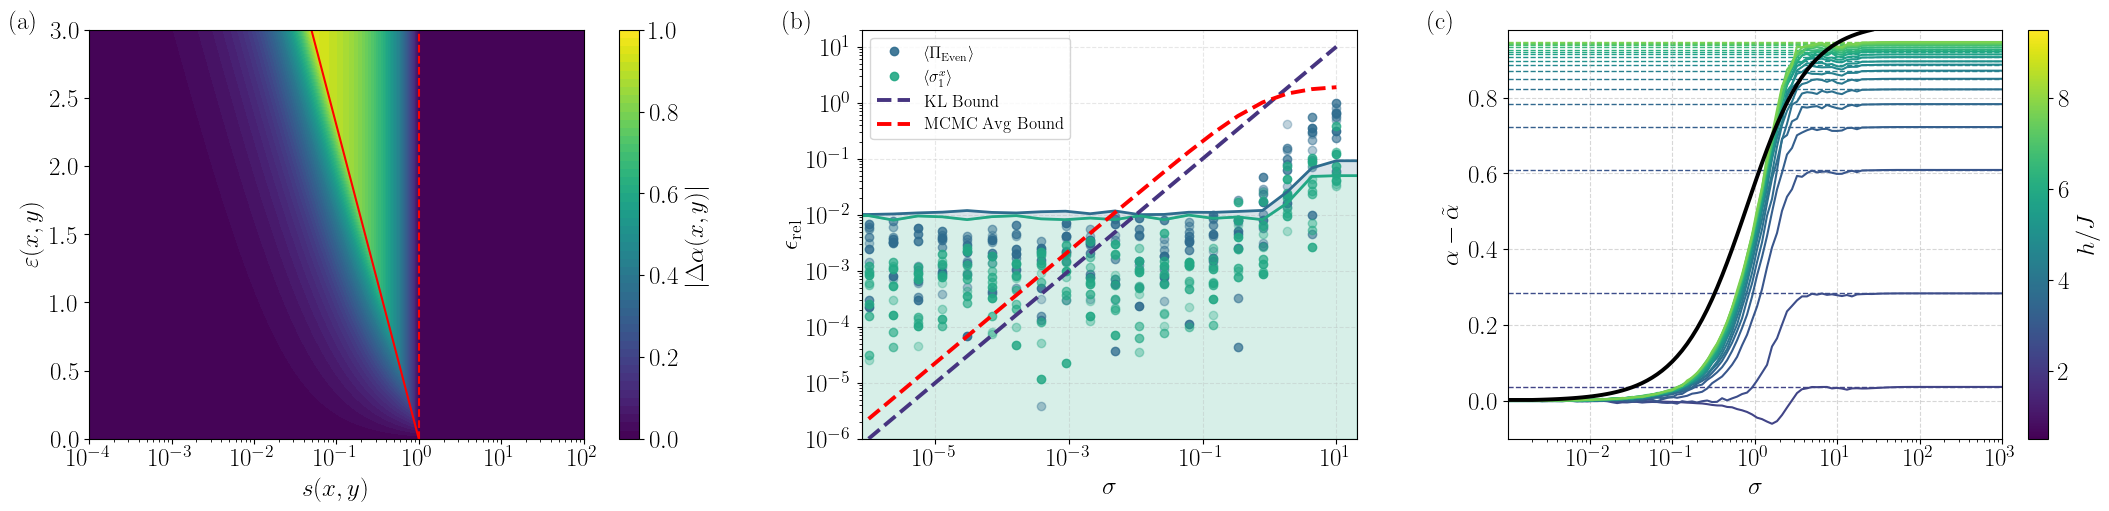

In [9]:
fig = plt.figure(figsize=(21, 5), constrained_layout=True)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.1, figure=fig)

ax = fig.add_subplot(gs[0])

letter_x, letter_y = -0.16, 1.05

gran = 3
s_vals = np.logspace(-4, 2, 400)
eps_vals = np.linspace(0., gran, 400)
S, EPS = np.meshgrid(s_vals, eps_vals)
D = Delta(S, EPS)

levels = np.linspace(0, 1, 51)

contour = ax.contourf(
    S, EPS, D,
    levels=levels,
    cmap="viridis",
    vmin=0, vmax=1,
    zorder=-1
)

ax.plot(s_vals, -np.log(s_vals), color="red", zorder=1)
ax.axvline(1.0, color="red", ls="--", zorder=1)

cbar = fig.colorbar(
    contour, ax=ax,
    fraction=0.046, pad=0.04
)
cbar.set_label(r"$|\Delta \alpha(x,y)|$")
cbar.set_ticks(np.linspace(0, 1, 6))

ax.set_xscale("log")
ax.set_ylim(0, gran)
ax.set_xlabel(r"$s(x,y)$")
ax.set_ylabel(r"$\varepsilon(x,y)$")
ax.text(letter_x, letter_y, "(a)", transform=ax.transAxes, fontweight="bold", va='top')

ax = fig.add_subplot(gs[1])

viridis = plt.get_cmap("viridis")
bound_kl_color = viridis(0.15)
bound_avg_color = "red"

alpha_spacing = np.linspace(0.3, 0.9, n_seeds)
sampling_error = {}

for obs_idx, obs_name in enumerate(obs_names):
    col = viridis(0.35 + 0.25 * obs_idx)

    means = np.zeros((2, len(sigma_list), len(seeds)))
    mc_errors = np.zeros((2, len(sigma_list), len(seeds)))

    for i, sigma in enumerate(sigma_list):
        for j, seed in enumerate(seeds):
            with open(f"./data_evs/{n}/{seed}/{obs_name}/stats_ref_{sigma:1.7f}.c", "rb") as f:
                stats_ref = pickle.load(f)
            with open(f"./data_evs/{n}/{seed}/{obs_name}/stats_noisy_{sigma:1.7f}.c", "rb") as f:
                stats_noisy = pickle.load(f)

            means[0, i, j] = stats_ref["Mean"]
            means[1, i, j] = stats_noisy["Mean"]
            mc_errors[0, i, j] = stats_ref["Sigma"]
            mc_errors[1, i, j] = stats_noisy["Sigma"]

    for j in range(len(seeds)):
        ax.plot(
            sigma_list,
            np.abs(means[0, :, j] - means[1, :, j]) / np.abs(means[0, :, j]),
            marker="o",
            ls="",
            color=col,
            alpha=alpha_spacing[j],
            label=label_map[obs_name] if j == len(seeds) - 1 else None,
        )

    sampling_error[obs_name] = np.nanmax(
        4 * np.sqrt((mc_errors[0] ** 2 + mc_errors[1] ** 2) / np.abs(means[0])), axis=1
    )

obs_pairs = list(zip(obs_names[:-1], obs_names[1:]))

for o1, o2 in obs_pairs:
    col = viridis(0.35)
    x_ext = [8e-7] + list(sigma_list) + [20]
    ax.plot(
        x_ext,
        [sampling_error[o1][0]] + list(sampling_error[o1]) + [sampling_error[o1][-1]],
        color=col,
        linewidth=2.0,
    )
    ax.fill_between(
        x_ext,
        [sampling_error[o1][0]] + list(sampling_error[o1]) + [sampling_error[o1][-1]],
        [sampling_error[o2][0]] + list(sampling_error[o2]) + [sampling_error[o2][-1]],
        color=col,
        alpha=0.18,
    )

o_last = obs_names[-1]
ax.plot(
    [8e-7] + list(sigma_list) + [20],
    [sampling_error[o_last][0]] + list(sampling_error[o_last]) + [sampling_error[o_last][-1]],
    color=viridis(0.6),
    linewidth=2.0,
)
ax.fill_between(
    [8e-7] + list(sigma_list) + [20],
    1e-6,
    [sampling_error[o_last][0]] + list(sampling_error[o_last]) + [sampling_error[o_last][-1]],
    color=viridis(0.6),
    alpha=0.18,
)

ax.plot(
    sigma_list,
    list(map(bound_KL, sigma_list)),
    color=bound_kl_color,
    linewidth=2.8,
    linestyle="--",
    label="KL Bound",
    zorder=10,
)

ax.plot(
    sigma_list,
    list(map(bound_avg, sigma_list)),
    color=bound_avg_color,
    linewidth=2.8,
    linestyle="--",
    label="MCMC Avg Bound",
    zorder=10,
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(8e-7, 20)
ax.set_ylim(1e-6, 20)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\epsilon_{\mathrm{rel}}$")
ax.grid(True, ls="--", alpha=0.3)
ax.legend(frameon=True)
ax.text(letter_x, letter_y, f'(b)', transform=ax.transAxes, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2])

colors = cm.viridis(np.linspace(0.2, 0.8, len(hs)))
norm = mcolors.Normalize(vmin=min(hs), vmax=max(hs))
sm = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
sm.set_array([])
# Main plot
for i, h in enumerate(hs):
    ax.plot(sigmas * 2, acceptance[i][0] - acceptance[i], color=colors[i], lw=1.5)
ax.plot(sigmas[:70] * 2, bound_avg(2 * sigmas[:70]) / 2, color="black", zorder=10, lw=2.8)
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\alpha-\tilde\alpha$")
ax.set_xlim(0, 1e3)
ax.set_ylim(-0.1, max(bound_avg(2 * sigmas[:70]) / 2))
ax.grid(ls="--", alpha=0.5)

for i in range(len(hs)):
    ax.axhline(acceptance[i][0], ls="--", color=colors[i], alpha=1, lw=1, zorder=0)

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r"$h/J$")

ax.text(letter_x, letter_y, "(c)", transform=ax.transAxes, fontweight="bold", va='top')

fig.savefig("figures/toy_model_and_noisy_rbm.pdf")
plt.show()